This code is to create monthly climatology files for DWI

In [ ]:
import dask
from dask.distributed import Client, wait
from dask import delayed

client = Client(n_workers=7, threads_per_worker=1) 
#client = Client()

client

In [3]:
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import glob
import os
from cfgrib.xarray_to_grib import to_grib

In [4]:
in_dir = f"/g/data/mn51/users/nb6195/BARRA_DWI"

In [5]:
infiles_dwi=glob.glob(in_dir+f'/BARRA_dwi*.nc')

In [6]:
dwi_ds = xr.open_mfdataset(infiles_dwi)['dwi']

In [7]:
dwi_ds

<xarray.DataArray 'dwi' (time: 16436, lat: 691, lon: 886)> Size: 40GB
dask.array<concatenate, shape=(16436, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01T12:00:00 ... 2023-12-31T1...
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Attributes: (12/14)
    long_name:              dwi computed from faux_ffdi and tasmax, from BARR...
    standard_name:          dwi
    program:                Australian Climate Service (ACS)
    summary:                Fire weather metric: BARRA dwi
    naming_authority:       Bureau of Meteorology
    publisher_type:         group
    ...                     ...
    publisher_url:          http://www.bom.gov.au
    creator_type:           institution
    creator_institution:    Bureau of Meteorology
    contact:                Naomi Benger (naomi.benger@bom.gov.au)
    institute_id:           BOM
    institution:            Bureau of Meteorology

Compute the monthly mean and print to file

In [ ]:
dwi_mean = dwi_ds.groupby('time.month').mean('time', keep_attrs=True)
dwi_mean

In [ ]:
dwi_mean.month

In [ ]:
#successfully computed and printed
#out_path = f"{in_dir}/DWI_mean_monthly.nc"

#encoding = {
#        "dwi": {
#            "dtype": "float32",
#            "zlib": True,
#            "complevel": 4, #mid-level compression, goes from 1 to 9
#            "chunksizes": (1, 691, 886)
#        }
#}

#dwi_mean.to_netcdf(out_path, engine="netcdf4", encoding=encoding)

#Tried printing to grob, didn't work
#out_path = f"{in_dir}/DWI_mean_monthly.grib"
#to_grib(dwi_mean, out_path)
#dwi_mean.to_netcdf(out_path, engine="cfgrib")

In [ ]:
#dwi_monthly_mean = xr.open_mfdataset('/g/data/mn51/users/nb6195/BARRA_DWI/DWI_mean_monthly.nc')['dwi']

In [ ]:
#plt.imshow(dwi_monthly_mean[11], origin='lower')
#plt.colorbar()

Now compute monthly percentiles

In [8]:
dwi_monthly = dwi_ds.groupby('time.month')

In [9]:
dwi_monthly

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [10]:
quantiles = [0.1,0.5,0.9]
quantile_labels = ["10","50", "90"]

In [11]:
#loop keeps crashing, do it one at a time
#for i in range(1, 13):
#    month = str(i)
#    dwi_ds = dwi_monthly[i]
#    if i < 10:
#        out_path = f"{in_dir}/DWI_perc_0{month}.nc"
#    else:
#        out_path = f"{in_dir}/DWI_perc_{month}.nc"
#    print(out_path)

#    dwi_perc = dwi_ds.chunk({'time':-1, 'lat':'auto','lon':'auto'}).quantile(quantiles, dim='time',keep_attrs=True).persist()

#    encoding = {
#        "dwi": {
#            "dtype": "float32",
#            "zlib": True,
#            "complevel": 4, #mid-level compression, goes from 1 to 9
#            "chunksizes": (3, 691, 886)
#            }
#    }

#    dwi_perc.to_netcdf(out_path, engine="netcdf4", encoding=encoding)
#    print('done')

In [11]:
i = 12

#Evaluate the quantiles
month = str(i)
dwi_ds = dwi_monthly[i]
if i < 10:
    out_path = f"{in_dir}/DWI_perc_0{month}.nc"
else:
    out_path = f"{in_dir}/DWI_perc_{month}.nc"
print(out_path)

dwi_perc = dwi_ds.chunk({'time':-1, 'lat':'auto','lon':'auto'}).quantile(quantiles, dim='time',keep_attrs=True).persist()

encoding = {
    "dwi": {
        "dtype": "float32",
        "zlib": True,
        "complevel": 4, #mid-level compression, goes from 1 to 9
        "chunksizes": (3, 691, 886)
        }
}

dwi_perc.to_netcdf(out_path, engine="netcdf4", encoding=encoding)
print('done')

/g/data/mn51/users/nb6195/BARRA_DWI/DWI_perc_12.nc
done


In [12]:
dwi_perc = xr.open_mfdataset('/g/data/mn51/users/nb6195/BARRA_DWI/DWI_perc_12.nc')['dwi']

In [13]:
dwi_perc

<xarray.DataArray 'dwi' (quantile: 3, lat: 691, lon: 886)> Size: 7MB
dask.array<open_dataset-dwi, shape=(3, 691, 886), dtype=float32, chunksize=(3, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon       (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * quantile  (quantile) float64 24B 0.1 0.5 0.9
Attributes: (12/14)
    long_name:              dwi computed from faux_ffdi and tasmax, from BARR...
    standard_name:          dwi
    program:                Australian Climate Service (ACS)
    summary:                Fire weather metric: BARRA dwi
    naming_authority:       Bureau of Meteorology
    publisher_type:         group
    ...                     ...
    publisher_url:          http://www.bom.gov.au
    creator_type:           institution
    creator_institution:    Bureau of Meteorology
    contact:                Naomi Benger (naomi.benger@bom.gov.au)
    institute_id:           BOM
    institution:            Bureau of Meteorology

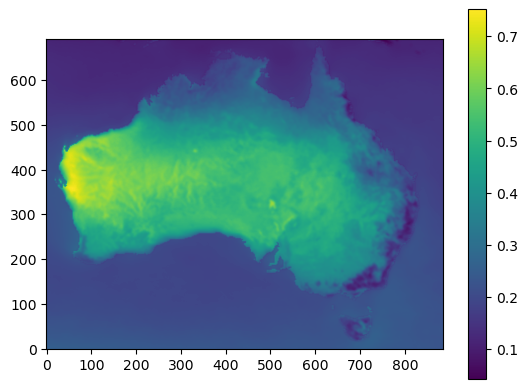

In [14]:
plt.imshow(dwi_perc[1], origin='lower')
plt.colorbar()

In [ ]:
#dwi_median = dwi_ds.groupby('time.month').median('time', keep_attrs=True)

In [ ]:
#dwi_median

In [ ]:
#out_path = f"{in_dir}/DWI_median_monthly.nc"

#encoding = {
#        "dwi": {
#            "dtype": "float32",
#            "zlib": True,
#            "complevel": 4, #mid-level compression, goes from 1 to 9
#            "chunksizes": (1, 691, 886)
#        }
#}

#dwi_median.to_netcdf(out_path, engine="netcdf4", encoding=encoding)

In [ ]:
#dwi_monthly_median = xr.open_mfdataset('/g/data/mn51/users/nb6195/BARRA_DWI/DWI_median_monthly.nc')['dwi']

Jess code

In [ ]:
def compute_percentile(base_period, percentile_threshold):
    """Compute percentiles across the time access"""
    percentile_array = base_period.quantile(percentile_threshold/100, dim='time')

    return percentile_array

input_array = input_array.astype(np.float32).chunk({'time':-1})
ds_perc = input_array.groupby('time.month').map(lambda x: compute_percentile(x, inargs.percentileThreshold))